In [1]:
import pandas as pd
import re,string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('tweets.csv')

In [3]:
# shape of the data
data.shape

(14640, 15)

In [4]:
# five elements from the top
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# decsription of data
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


C:\Users\ankit\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


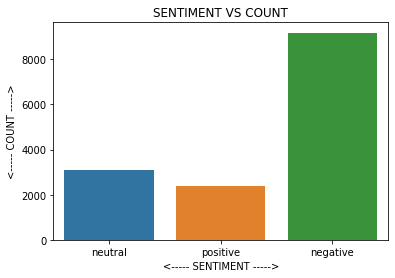

In [6]:
sns.countplot(data['airline_sentiment'])
plt.xlabel('<----- SENTIMENT ----->')
plt.ylabel('<----- COUNT ----->')
plt.title('SENTIMENT VS COUNT')
plt.show()

In [7]:
data=data[['airline_sentiment','text']]

In [8]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Text preprocessing

In [9]:
# removing the html tags
def clean_html(text):
    clean=re.compile('<.*?>')
    cleantext=re.sub(clean,'',text)
    return cleantext
    
# first round of cleaning
def clean_text1(text):
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text

# second round of cleaning
def clean_text2(text):
    text=re.sub('[''"",,,]','',text)
    text=re.sub('\n','',text)
    return text
    
cleaned_html=lambda x:clean_html(x)
cleaned1=lambda x:clean_text1(x)
cleaned2=lambda x:clean_text2(x)

data['text']=pd.DataFrame(data.text.apply(cleaned_html))
data['text']=pd.DataFrame(data.text.apply(cleaned1))
data['text']=pd.DataFrame(data.text.apply(cleaned2))

In [10]:
print(data['text'][0],data['airline_sentiment'][0])

virginamerica what dhepburn said neutral


In [11]:
from keras.models import Sequential
from keras.layers import LSTM,Embedding,Dense
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
max_features=1000
length=100
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X,maxlen=length)
Y=pd.get_dummies(data['airline_sentiment']).values

## Defining the model

In [13]:
vec_len=64
model=Sequential()
model.add(Embedding(max_features,vec_len,input_length=length))
model.add(LSTM(128))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 163,203
Trainable params: 163,203
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,Y_train,Y_test=tts(X,Y,test_size=0.3,random_state=42)

In [15]:
model.fit(X_train,Y_train,epochs=8,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/8
321/321 [==============================] - 11s 35ms/step - loss: 0.7063 - accuracy: 0.7026 - val_loss: 0.5611 - val_accuracy: 0.7789
Epoch 2/8
321/321 [==============================] - 10s 30ms/step - loss: 0.5072 - accuracy: 0.8016 - val_loss: 0.5234 - val_accuracy: 0.7889
Epoch 3/8
321/321 [==============================] - 10s 30ms/step - loss: 0.4592 - accuracy: 0.8218 - val_loss: 0.5050 - val_accuracy: 0.7971
Epoch 4/8
321/321 [==============================] - 10s 31ms/step - loss: 0.4291 - accuracy: 0.8354 - val_loss: 0.5289 - val_accuracy: 0.7851
Epoch 5/8
321/321 [==============================] - 10s 31ms/step - loss: 0.4054 - accuracy: 0.8389 - val_loss: 0.5259 - val_accuracy: 0.7905
Epoch 6/8
321/321 [==============================] - 10s 30ms/step - loss: 0.3809 - accuracy: 0.8531 - val_loss: 0.5258 - val_accuracy: 0.7958
Epoch 7/8
321/321 [==============================] - 10s 31ms/step - loss: 0.3589 - accuracy: 0.8599 - val_loss: 0.5799 - val_accuracy: 0.7735